# Network dynamics

We use leaky integrate-and-fire neurons with conductance-based synapses (see Section 13.6.2 of Gerstner, Kistler, Naud, and Paninski (http://neuronaldynamics.epfl.ch/index.html)).

The $i$-th neuron's membrane voltage $V^i(t)$ is given by:

$\tau_m\cfrac{dV^i}{dt} = -(V^i - E_L) - g_{AMPA}(t)(V^i - E_{AMPA}) - g_{NMDA}(t)(V^i - E_{NMDA}) - g_{GABA}(t)(V^i - E_{GABA}) + I_{ext}(t)$

where $\tau_m$ is the membrane time constant, $g_L$ and $E_L$ are the leak conductance and reversal potential, respectively, $g_{AMPA}$ and $E_{AMPA}$ the AMPA conductance and reversal potential, respectively, etc., and $I_{ext}$ is any external current injected directly by an "experimenter".

The synaptic conductances are given by:

$g_{SYN} = \sum\limits_j w_{ij} \sum\limits_{k(j)} h_{SYN}(t - t^{k(j)})$

where $g_{SYN} \in \{g_{AMPA}, g_{NMDA}, g_{GABA}\}$, $j$ indexes upstream neurons, $w_{ij}$ is the synaptic strength from neuron $j$ onto neuron $i$, $k(j)$ is the $k$-th spike time of upstream neuron $j$, and $h_{SYN}(t)$ is the synaptic activation for synapse type $SYN$. These conductances are relative to the leak conductance and have no units.

In short, the synaptic conductance of neuron $i$ caused by neuron $j$'s spike train is a convolution of neuron $j$'s spike train (where each spike is a delta function) with synaptic activation function $h(t)$ (e.g., a 1-sided decaying exponential), scaled by the synaptic weight $w_{ij}$.

# Synaptic EPSPs for a single neuron

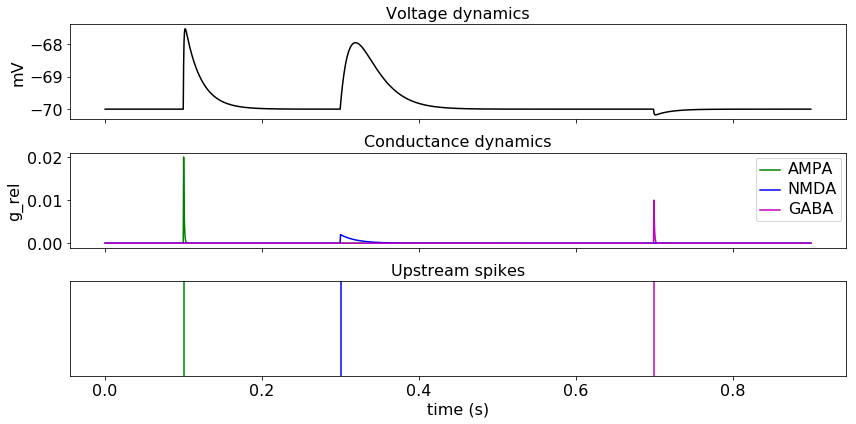

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

from ntwk import LIFNtwk
import plot

W_AMPA = 0.02
W_NMDA = 0.002
W_GABA = 0.01
DT = 0.0005  # (s)
SYNS = ['AMPA', 'NMDA', 'GABA']

NTWK_KWARGS = {
    'tau_m': 0.02,  # (s)
    'e_leak': -0.07,  # (V)
    'v_th': -0.036,  # (V)
    'v_reset': -0.07,  # (V)
    'tau_r': 0.002,  # (s)
    'es_rev': {'AMPA': 0, 'NMDA': 0, 'GABA': -0.08},  # (V)
    'taus_syn': {'AMPA': 0.001, 'NMDA': 0.02, 'GABA': 0.001},  # (s)
    'ws_rcr': {syn: np.array([[0.]]) for syn in SYNS},  # (unitless)
    'ws_up': {
        'AMPA': np.array([[W_AMPA, 0, 0]]),
        'NMDA': np.array([[0, W_NMDA, 0]]),
        'GABA': np.array([[0, 0, W_GABA]]),
    },
    'dt': DT,  # (s)
}

# make new 1-neuron ntwk
ntwk = LIFNtwk(**NTWK_KWARGS)

# make upstream spike stim
ts = np.arange(0, 0.9, NTWK_KWARGS['dt'])

spks_up = np.zeros(ts.shape + (3,), dtype=int)
# AMPA input
spks_up[int(0.1/DT), 0] = 1
# NMDA input
spks_up[int(0.3/DT), 1] = 1
# GABA input
spks_up[int(0.7/DT), 2] = 1

# run ntwk
vs_init = NTWK_KWARGS['e_leak'] * np.ones(1)
gs_init = {syn: np.zeros(1) for syn in SYNS}
ntwk_response = ntwk.run(spks_up=spks_up, vs_init=vs_init, gs_init=gs_init)

# plot membrane potential, conductances, and upstream spikes
fig, axs = plt.subplots(3, 1, figsize=(12, 6), sharex=True, tight_layout=True)

# membrane potential
axs[0].plot(ts, 1000 * ntwk_response.vs[:, 0], color='k')
axs[0].set_ylabel('mV')
axs[0].set_title('Voltage dynamics')

# conductances
h_a = axs[1].plot(ts, ntwk_response.gs['AMPA'], color='g', label='AMPA')[0]
h_n = axs[1].plot(ts, ntwk_response.gs['NMDA'], color='b', label='NMDA')[0]
h_g = axs[1].plot(ts, ntwk_response.gs['GABA'], color='m', label='GABA')[0]
axs[1].set_ylabel('g_rel')
axs[1].set_title('Conductance dynamics')
axs[1].legend(handles=[h_a, h_n, h_g])

# upstream spikes
axs[2].axvline(0.1, color='g')
axs[2].axvline(0.3, color='b')
axs[2].axvline(0.7, color='m')
axs[2].set_title('Upstream spikes')
axs[2].yaxis.set_visible(False)

axs[2].set_xlabel('time (s)')

for ax in axs:
    plot.set_font_size(ax, 16)

# Output firing rate vs excitatory spike input for single neuron

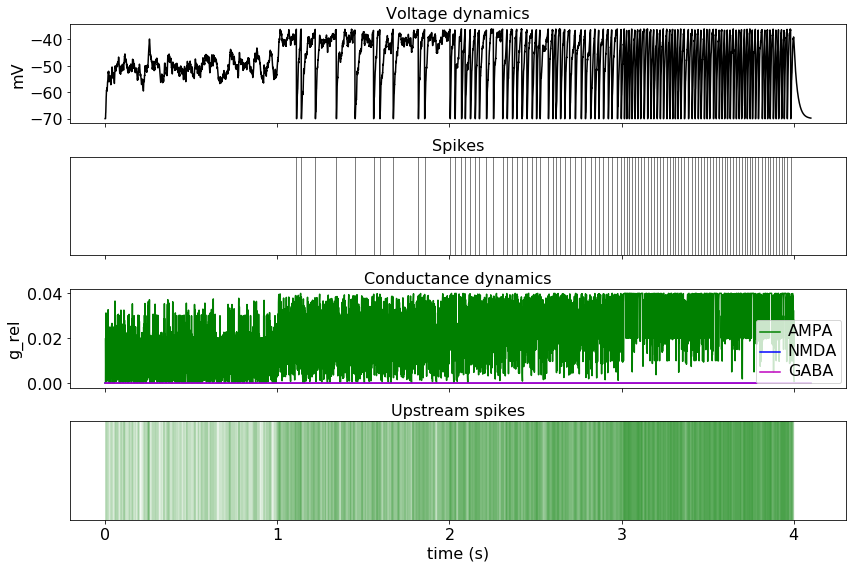

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

from ntwk import LIFNtwk
import plot

W_AMPA = 0.02
W_NMDA = 0.002
W_GABA = 0.01
DT = 0.0005  # (s)
SYNS = ['AMPA', 'NMDA', 'GABA']

NTWK_KWARGS = {
    'tau_m': 0.02,  # (s)
    'e_leak': -0.07,  # (V)
    'v_th': -0.036,  # (V)
    'v_reset': -0.07,  # (V)
    'tau_r': 0.002,  # (s)
    'es_rev': {'AMPA': 0, 'NMDA': 0, 'GABA': -0.08},  # (V)
    'taus_syn': {'AMPA': 0.001, 'NMDA': 0.02, 'GABA': 0.001},  # (s)
    'ws_rcr': {syn: np.array([[0.]]) for syn in SYNS},  # (unitless)
    'ws_up': {
        'AMPA': np.array([[W_AMPA, 0, 0]]),
        'NMDA': np.array([[0, W_NMDA, 0]]),
        'GABA': np.array([[0, 0, W_GABA]]),
    },
    'dt': DT,  # (s)
}

# make new 1-neuron ntwk
ntwk = LIFNtwk(**NTWK_KWARGS)

# make upstream spike stims
ts = np.arange(0, 4.1, NTWK_KWARGS['dt'])

spks_up_ampa = np.zeros(ts.shape + (3,))

starts = [0, 1, 2, 3]
freqs = [500, 1000, 1300, 1700]
itvl = 1

for start, freq in zip(starts, freqs):
    start_tp = int(start/DT)
    end_tp = start_tp + int(itvl/DT)
    
    p_spk = freq * DT
    spks_ = np.random.rand(end_tp-start_tp) < p_spk
    spks_up_ampa[start_tp:end_tp, 0] = spks_.astype(int)
    
# run ntwk
vs_init = NTWK_KWARGS['e_leak'] * np.ones(1)
gs_init = {syn: np.zeros(1) for syn in SYNS}
ntwk_response = ntwk.run(spks_up=spks_up_ampa, vs_init=vs_init, gs_init=gs_init)

# plot membrane potential, conductances, and upstream spikes
fig, axs = plt.subplots(4, 1, figsize=(12, 8), sharex=True, tight_layout=True)

# membrane potential
axs[0].plot(ts, 1000 * ntwk_response.vs[:, 0], color='k')
axs[0].set_ylabel('mV')
axs[0].set_title('Voltage dynamics')

# spikes
for spk_tp in ntwk_response.spks[:, 0].nonzero()[0]:
    axs[1].axvline(spk_tp*DT, color='k', lw=0.5)
    
axs[1].set_title('Spikes')
axs[1].yaxis.set_visible(False)

# conductances
h_a = axs[2].plot(ts, ntwk_response.gs['AMPA'], color='g', label='AMPA')[0]
h_n = axs[2].plot(ts, ntwk_response.gs['NMDA'], color='b', label='NMDA')[0]
h_g = axs[2].plot(ts, ntwk_response.gs['GABA'], color='m', label='GABA')[0]
axs[2].set_ylabel('g_rel')
axs[2].set_title('Conductance dynamics')
axs[2].legend(handles=[h_a, h_n, h_g])

# upstream spikes
for spk_tp in spks_up_ampa[:, 0].nonzero()[0]:
    axs[3].axvline(spk_tp*DT, color='g', lw=0.1)
    
axs[3].set_title('Upstream spikes')
axs[3].yaxis.set_visible(False)

axs[3].set_xlabel('time (s)')

for ax in axs:
    plot.set_font_size(ax, 16)